# Depression detection in elderly people

This project is property of Sereendepia Research (http://serendeepia.com/) and supervised by its team of experts Jorge Muñoz (CEO), Javier Ordoñez (CIO) and Raul Arrabales (CBDO) who helped me to develop this project as a Minimum Viable Product. I was able to work with this team of experts by making an intership in this company, as part of my Master's degree in Artificial intelligence in the International University of La Rioja (UNIR).

The aim of this project is to create a virtual robot to detect depression traits in elderly people at home, that can be created for instance when they are alone.

To detect depression traits we have used the DAIC-WOZ database from the University of Southern California, which has 189 participants with audio recordings and transcripts, and the PHQ-8 score associated to each particpant.




## Work plan of this project

1. Gathering data about depression traits and develop and working plan.

2. Analyze the database.

3. Tensorflow modelling.

4. Training and validation

5. Design, parameters, hyperparameters and algorithm selection.

### Preparing the enviroment

In [5]:
!pip install librosa
!pip install pydub
!pip install pydrive

In [0]:
from pydub import AudioSegment
from scipy import signal
import pandas as pd
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
from librosa import display
import pandas as pd
from sklearn.metrics import confusion_matrix
import keras
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Embedding
from keras.layers import Conv2D, MaxPooling2D, ConvLSTM2D, LSTM, Bidirectional
from keras.optimizers import sgd
import tensorflow as tf
import numpy as np
import itertools
import math
import time

/usr/local/lib/python3.6/dist-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using TensorFlow backend.


In [1]:
# Mount google drive to access DAIC-WOZ database 

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Function definition to calculate spectograms and confussion matrix

In [0]:
#Compute spectogram of each audio

SR = 22050
def get_short_time_fourier_transform(soundwave):
    return librosa.stft(soundwave, n_fft=256)

def short_time_fourier_transform_amplitude_to_db(stft):
    return librosa.amplitude_to_db(stft)

def soundwave_to_np_spectogram(soundwave):
    step1 = get_short_time_fourier_transform(soundwave)
    step2 = short_time_fourier_transform_amplitude_to_db(step1)
    step3 = step2/100
    return step3

def inspect_data(sound):
#    plt.figure()
#    plt.plot(sound)
#    IPython.display.display(IPython.display.Audio(sound, rate=SR))
    a = get_short_time_fourier_transform(sound)
    Xdb = short_time_fourier_transform_amplitude_to_db(a)
#    plt.figure()   
#    plt.imshow(Xdb)    
#    plt.show()
#    print (Xdb.shape)
#    print("Length per sample: %d, shape of spectogram: %s, max: %f min: %f" % (len(sound), str(Xdb.shape), Xdb.max(), Xdb.min()))
    return Xdb

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Create the arrays that contain the information that will be used to train the system, such as the processed audios and number tag of each participant.

In [0]:
#Variable creation. They will contain the information neccesary to train the system.

i = 0
j = 0
k = 0
number_list_train = ['']
number_list_test = ['']
file_count = 60
file_count2 = 35
input_array_train = ['']
phq8_array_train = ['']
input_array_train *= file_count
phq8_array_train *= file_count
number_list_train *= file_count
input_array_test = ['']
phq8_array_test = ['']
input_array_test *= file_count2
phq8_array_test *= file_count2
number_list_test *= file_count2

### Segmentation of .wav from the DAIC-WOZ database

The segmentation is done using the transcript that the database provides for each participant, is this transcript would not exists, a speaker diarization library should be used.

This way we get .wav files that only contains the audio from each participant, erasing the interviewer´s audio, which is irrelevant for this project. We do this to achieve better performance in the training and validation of the system.

In [0]:
number = 0
l = 0
m = 0

# Open data file, which contains the particpants used in the training

data = open('C:/Users/Fran/Desktop/Database/datos1.txt', 'r', encoding='utf-8-sig')

# Segmentate using the time info of the transcript of each participant, also concatenate
# each segmented audio to the end of the sums of all audios, to create a .wzv that only contains
# the audio from the particpant. The audio from the interviewer gets erased using this segmentation.

# The following code is for the train set.

for line in data:
    mylist = line.split(',')
    number = mylist[0]
    
    # Open .wav files
    df = pd.read_csv('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' 
                     + str(number) + '_TRANSCRIPT.csv', header=0)
    while i < len (df):
        a = df.iloc[i].str.split()
        if a[0][2] == 'Participant' and j == 0: 
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav', format="wav")
            j = 1
        elif a[0][2] == 'Participant':
            
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba/' + str(number) + 'segmento.wav', format="wav")
            sound1 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav')
            sound2 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba/' + str(number) + 'segmento.wav')

            combined_sounds = sound1 + sound2
            combined_sounds.export('C:/Users/Fran/Desktop/prueba/' + str(number) + '.wav', format="wav")
        i += 1

# Complete the variables created with the information needed, .wav, number tag of the participant.

    w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    input_array_train[l] = w
    number_list_train[l] = number
    phq8_array_train[l] = mylist[1]
    l += 1
    j = 0
    i = 0
    


In [0]:
i = 0
l = 0
m = 0

# Open data file, which contains the particpants used in the validation 

data1 = open('C:/Users/Fran/Desktop/Database/datos2_dev.txt', 'r', encoding='utf-8-sig')

# Segmentate using the time info of the transcript of each participant, also concatenate
# each segmented audio to the end of the sums of all audios, to create a .wzv that only contains
# the audio from the particpant. The audio from the interviewer gets erased using this segmentation.

# The following code is for the validation set.

for line in data1:
    mylist = line.split(',')
    number = mylist[0]
    
    # Open .wav files
    df = pd.read_csv('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' 
                     + str(number) + '_TRANSCRIPT.csv', header=0)
    while i < len (df):
        a = df.iloc[i].str.split()
        if a[0][2] == 'Participant' and j == 0: 
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav', format="wav")
            j = 1
        elif a[0][2] == 'Participant':
            
            newAudio = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' 
                                             + str(number) + '_P/' + str(number) + '_AUDIO.wav')
            t1 = int(float(a[0][0]) * 1000)
            t2 = int(float(a[0][1]) * 1000)
            newAudio = newAudio[t1:t2]
            newAudio.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + 'segmento.wav', format="wav")
            sound1 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav')
            sound2 = AudioSegment.from_wav('C:/Users/Fran/Desktop/prueba_test/' + str(number) + 'segmento.wav')

            combined_sounds = sound1 + sound2
            combined_sounds.export('C:/Users/Fran/Desktop/prueba_test/' + str(number) + '.wav', format="wav")
        i += 1
        
# Complete the variables created with the information needed, .wav, number tag of the participant.

    w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    input_array_test[l] = w
    number_list_test[l] = number
    phq8_array_test[l] = mylist[1]
    l += 1
    j = 0
    i = 0 

### Calculation of the length of each segmented audio.

This information could be used in the future to create windows of a certain lenght of audio of each segmented and processed audio.

In [0]:
l = 0
data = open('/content/drive/My Drive/datos1_prueba.txt', 'r', encoding='utf-8-sig')
for line in data:
    mylist = line.split(',')
    number = mylist[0]
    #w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    #input_array_train[l] = w
    number_list_train[l] = number
    phq8_array_train[l] = mylist[1]
    l += 1
    
l = 0
data1 = open('/content/drive/My Drive/datos2_dev.txt', 'r', encoding='utf-8-sig')
for line in data1:
    mylist = line.split(',')
    number = mylist[0]
    #w = AudioSegment.from_wav('C:/Users/Fran/Desktop/Database/' + str(number) + '_P/' + str(number) + '_AUDIO.wav')
    #input_array_test[l] = w
    number_list_test[l] = number
    phq8_array_test[l] = mylist[1]
    l += 1

In [0]:
# Calculation of .wav leght so we can move de time window from the start to the end without any problems

len_list_train = ['']
len_list_test = ['']
len_list_train *= file_count
len_list_test *= file_count2
i = 0
j = 0


for audio_number in number_list_train:
    Audio_train = AudioSegment.from_wav('/content/drive/My Drive/prueba/' + str(audio_number) + '.wav')
    len_list_train[i] = int(len(Audio_train) / (1000))
    i += 1
    
    
for audio_number in number_list_test:
    Audio_test = AudioSegment.from_wav('/content/drive/My Drive/prueba_test/' + str(audio_number) + '.wav')
    len_list_test[j] = int(len(Audio_test) / (1000))
    j += 1
    


### Data Augmentation 

We use data augmentation to increase the number of samples to train the system. We take a time window and move it along the .wav that was segmented. We can create as many windows as we want, in this case we create 10 samples of each segmented .wav file. Also we add the PHQ-8 score (predicted value) of each new sample.

In [0]:
# Audio sample creation in each .wav file by moving the timw window along the .wav
# The length of the time window can vary and can be adjusted, also the number of samples of each .wav file
# can be increased or decreased

t1_train_ini = 5 * 1000
t1_test_ini = 5 * 1000
t2_train_end = 8 * 1000
t2_test_end = 8 * 1000
i = 0
for audio_number in number_list_train:  
    i = 0
    while i<10:
        Audio_train = AudioSegment.from_wav('/content/drive/My Drive/prueba/' + str(audio_number) + '.wav')
        t1_train_ini_ = t1_train_ini + ((i*3)+(i))*1000
        t2_train_end_ = t2_train_end + ((i*3)+(i))*1000
        Audio_train = Audio_train[t1_train_ini_:t2_train_end_]
        Audio_train.export('/content/drive/My Drive/database_train/' + str(audio_number) + '_' + str(i) + '.wav', format="wav")
        i += 1
        time.sleep(1)

t1_train_ini = 5 * 1000
t1_test_ini = 5 * 1000
t2_train_end = 8 * 1000
t2_test_end = 8 * 1000
i = 0   
for audio_number in number_list_test:
    i = 0
    while i<10:
        Audio_test = AudioSegment.from_wav('/content/drive/My Drive/prueba_test/' + str(audio_number) + '.wav')
        t1_train_ini_ = t1_train_ini + ((i*3)+(i))*1000
        t2_train_end_ = t2_train_end + ((i*3)+(i))*1000
        Audio_test = Audio_test[t1_train_ini_:t2_train_end_]
        Audio_test.export('/content/drive/My Drive/database_test/' + str(audio_number) + '_' + str(i) + '.wav', format="wav")
        time.sleep(1)
        i += 1

In [0]:
#data augmentation PHQ-8 score (predicted value)

multiplier = 10
phq8_array_train_extended = np.ndarray(shape = (60*multiplier,1))
phq8_array_test_extended = np.ndarray(shape = (35*multiplier,1))
i = 0
j = 0
for valor in phq8_array_train:
    while i < multiplier:
        phq8_array_train_extended[j] = valor
        i += 1
        j += 1
    i = 0

i = 0
j = 0
for valor in phq8_array_test:
    while i < multiplier:
        phq8_array_test_extended[j] = valor
        i += 1
        j += 1
    i = 0

### Spectograms calculation of each sample of audio

The spectogram shows the information of the audio in the frequency domain, as it is shown in the next example. The frequencies shown are up to ~3600 MHz, the information shown above that frequency is not interesting for this project so we eliminate tis part of each spectogram.

In [0]:
# Read the audio sample and calulate the normalized spectogram

X, sr = librosa.load('/content/drive/My Drive/database_train/' + '303' + '_' + '0' + '.wav')
prueba = soundwave_to_np_spectogram(X)

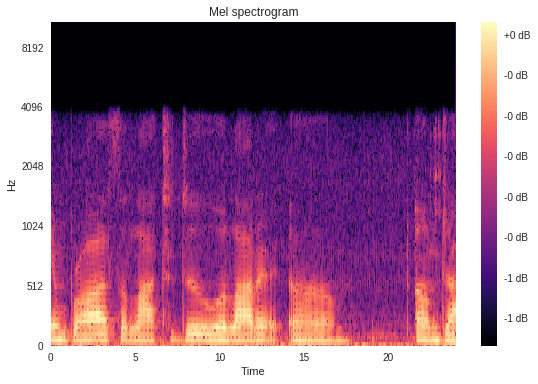

In [0]:
# Show the spectogram

librosa.display.specshow(prueba,
                         y_axis='mel',
                         x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [0]:
# Spectograms of each segmented audio


Xdb_train = ['']
Xdb_train_normalized = ['']
Xdb_train *= file_count
Xdb_train_normalized *= file_count

Xdb_train *= 10

Xdb_test = ['']
Xdb_test_normalized = ['']
Xdb_test *= file_count2
Xdb_test_normalized *= file_count2

Xdb_test *= 10

i = 0
j = 0
for audio_train in number_list_train:
    j = 0
    while j<10:
        X, sr = librosa.load('/content/drive/My Drive/database_train_0.3/' + str(audio_train) + '_' + str(j) + '.wav')
        Xdb_train[i] = abs(soundwave_to_np_spectogram(X))
        #Xdb_train_normalized[i] = tf.log(tf.abs(Xdb_train[i]) + 0.01)
        i += 1
        j += 1

i = 0
j = 0
for audio_test in number_list_test:
    j = 0
    while j<10:
        X, sr = librosa.load('/content/drive/My Drive/database_test_0.3/' + str(audio_test) + '_' + str(j) + '.wav')
        Xdb_test[i] = abs(soundwave_to_np_spectogram(X))
        #Xdb_test_normalized[i] = tf.log(tf.abs(Xdb_test[i]) + 0.01)
        i += 1
        j += 1

/usr/local/lib/python3.6/dist-packages/librosa/core/spectrum.py:960: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [0]:
# Size of the spectogram. Every sample has the same lenght so only 1 size is calculated.

alto, ancho = np.shape(Xdb_train[0])

### Reshaping the data input to the system.

We reshape the spectogram matrix to feed it in a LSTM network or a Convolutional network.

In [0]:
# Reshaping for a convolutional network

multiplier = 10
Xdb_train_array = np.ndarray(shape = (60*multiplier,95,ancho))
Xdb_test_array = np.ndarray(shape = (35*multiplier,95,ancho))

i = 0
for train in Xdb_train:
    Xdb_train_array[i] = train[0:95,:]
    i += 1
    
i = 0
for test in Xdb_test:
    Xdb_test_array[i] = test[0:95,:]
    i += 1
    
Xdb_train_array = Xdb_train_array.reshape(600,95, ancho, 1)
Xdb_test_array = Xdb_test_array.reshape(350,95, ancho, 1)

In [0]:
# Reshaping for a LSTM network

Xdb_train_array_lstm = np.ndarray(shape = (60*multiplier,95,ancho))
Xdb_test_array_lstm = np.ndarray(shape = (35*multiplier,95,ancho))

i = 0
for train in Xdb_train:
    Xdb_train_array_lstm[i] = train[0:95,:]
    i += 1
    
i = 0
for test in Xdb_test:
    Xdb_test_array_lstm[i] = test[0:95,:]
    i += 1
    
Xdb_train_array_lstm = Xdb_train_array_lstm.reshape(60*multiplier ,95*ancho)
Xdb_test_array_lstm = Xdb_test_array_lstm.reshape(35*multiplier, 95*ancho)

Xdb_train_array_lstm = np.reshape(Xdb_train_array_lstm, (Xdb_train_array_lstm.shape[0], 1, Xdb_train_array_lstm.shape[1]))
Xdb_test_array_lstm = np.reshape(Xdb_test_array_lstm, (Xdb_test_array_lstm.shape[0], 1, Xdb_test_array_lstm.shape[1]))

### Creation of LSTM model and Convolutional model

In [0]:
num_classes = 2
batch_size = 64
epochs = 10

# convert class vectors to binary class matrices
phq8_array_train = keras.utils.to_categorical(phq8_array_train_extended, num_classes)
phq8_array_test = keras.utils.to_categorical(phq8_array_test_extended, num_classes)

In [0]:
# Convolutional model

model = Sequential()
model.add(Conv2D(80, kernel_size=(3, 3), activation='relu', input_shape=(95,ancho,1)))
model.add(MaxPooling2D(pool_size=(4, 3)))
model.add(Conv2D(80, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 93, 102, 80)       800       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 34, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 21, 32, 80)        57680     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 10, 80)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               4301056   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

In [0]:
# LSTM model

model1 = Sequential()
model1.add(Bidirectional(LSTM(128, return_sequences=True),
                        input_shape=(1, 95*ancho)))
model1.add(Bidirectional(LSTM(64)))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(num_classes, activation='softmax'))

model1.summary()
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.rmsprop(),
              metrics=['accuracy'])
#categorical_crossentropy


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 1, 256)            10249216  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 130       
Total params: 10,421,954
Trainable params: 10,421,954
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True,
               input_shape=(1, alto*ancho))))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(32, return_sequences=True)))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(32)))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.summary
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### Training and validation phase

In [0]:
model.fit(Xdb_train_array, phq8_array_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(Xdb_test_array, phq8_array_test))
score = model.evaluate(Xdb_test_array, phq8_array_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 600 samples, validate on 350 samples
Epoch 1/10
600/600 [==============================] - 18s 30ms/step - loss: 0.7030 - acc: 0.4850 - val_loss: 0.6900 - val_acc: 0.6571
Epoch 2/10
600/600 [==============================] - 16s 27ms/step - loss: 0.6949 - acc: 0.4900 - val_loss: 0.7117 - val_acc: 0.3429
Epoch 3/10
600/600 [==============================] - 16s 26ms/step - loss: 0.6942 - acc: 0.5000 - val_loss: 0.7002 - val_acc: 0.3429
Epoch 4/10
600/600 [==============================] - 16s 26ms/step - loss: 0.6976 - acc: 0.4900 - val_loss: 0.6971 - val_acc: 0.3429
Epoch 5/10
600/600 [==============================] - 16s 27ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6946 - val_acc: 0.3429
Epoch 6/10
600/600 [==============================] - 16s 26ms/step - loss: 0.6928 - acc: 0.5100 - val_loss: 0.6857 - val_acc: 0.6571
Epoch 7/10
600/600 [==============================] - 16s 27ms/step - loss: 0.6951 - acc: 0.4767 - val_loss: 0.6927 - val_acc: 0.6457
Epoch 8/10
600/6

In [0]:
model1.fit(Xdb_train_array_lstm, phq8_array_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(Xdb_test_array_lstm, phq8_array_test))
score = model1.evaluate(Xdb_test_array_lstm, phq8_array_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 600 samples, validate on 350 samples
Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 0.6954 - acc: 0.4867 - val_loss: 0.6997 - val_acc: 0.3429
Epoch 2/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6923 - acc: 0.5100 - val_loss: 0.6916 - val_acc: 0.6571
Epoch 3/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6940 - acc: 0.5200 - val_loss: 0.6913 - val_acc: 0.6571
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6951 - acc: 0.4917 - val_loss: 0.6973 - val_acc: 0.3429
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6964 - acc: 0.4583 - val_loss: 0.6983 - val_acc: 0.3429
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6946 - acc: 0.4967 - val_loss: 0.6917 - val_acc: 0.6571
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 0.6937 - acc: 0.5083 - val_loss: 0.6876 - val_acc: 0.6571
Epoch 8/10
600/600 [==========

In [0]:
prediccion = model.predict(Xdb_test_array, batch_size=batch_size, verbose=1, steps=None)
for i in prediccion:
    print('Valor predicho:', i)

### Confussion Matrix

In [0]:
conf_matrix_pred = ['']
conf_matrix_pred *= 35
j = 0
for i in prediccion:
    conf_matrix_pred[j] = i.argmax(axis=0)
    print ("Clase: " + str(i.argmax(axis=0)))
    j += 1

Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0


In [0]:
conf_matrix_test = ['']
conf_matrix_test *= 35
j = 0
for i in phq8_array_test:
    conf_matrix_test[j] = i.argmax(axis=0)
    print ("Clase: " + str(i.argmax(axis=0)))
    j += 1

Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 1
Clase: 1
Clase: 1
Clase: 1
Clase: 0
Clase: 1
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 1
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 0
Clase: 1
Clase: 0
Clase: 0
Clase: 0
Clase: 0


In [0]:
cnf_matrix = confusion_matrix(conf_matrix_test,conf_matrix_pred)

Confusion matrix, without normalization
[[23  0]
 [12  0]]


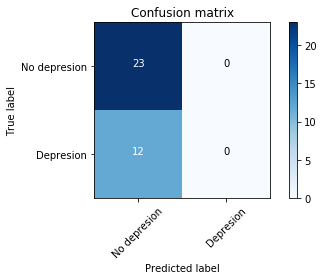

In [0]:
plot_confusion_matrix(cnf_matrix, classes=['No depresion','Depresion'],
                      title='Confusion matrix')